# NEO Crisis <i>!</i> — Trajectories

The aliens fear us! Yes, they <b>fear</b> us!

We know this, because they have tried to disguise their work. They fear that if we make it through this night, if we destroy the objects they have sent hurtling toward the earth, that we <b>WILL</b> strike back!

## Basic Rules

The objects approaching earth have the following characteristics:
- they obey Netwonian laws of physics (there are no relativistic effects at play, no matter how fast the objects move)
- there are no orbital mechanics involved: objects move in simple spirals and are not affected by gravity forces between other objects
- they are on "ballistic" trajectories: they move in an entirely deterministic fashion, and once they are launched, they experience no additional "thrust" (acceleration)

## Setup

This notebook requires only `numpy` and `matplotlib` to run. These are available with the default installation of Anaconda (http://anaconda.com/downloads).

Even so, let's use the `watermark` (https://github.com/rasbt/watermark) extension just to make sure we clearly enumerate our dependencies: 

In [1]:
# NOTE: for informational purposes only - you can skip this cell

% load_ext watermark
% watermark -v -m -p numpy,matplotlib,scipy,ipywidgets

CPython 3.6.3
IPython 6.1.0

numpy 1.13.3
matplotlib 2.1.0
scipy 0.19.1
ipywidgets 7.0.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.17.2-1-zen
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


### imports & helper functions

In [2]:
# NOTE: run this cell once

from collections import namedtuple
from numpy import arange, linspace, argmax, mgrid, sin, cos, pi, clip, sqrt, arccos, arctan2
from matplotlib.pyplot import figure, subplot, ion, ioff
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
from ipywidgets import interact, FloatSlider
from scipy.constants import c

def equal_aspect(x, y, z, ax):
    'hack to force 3D graphs to have equal aspect ratio on all axes'
    rng = max(x.max() - x.min(), y.max() - y.min(), z.max() - z.min())
    x = 0.5 * rng * mgrid[-1:2:2, -1:2:2, -1:2:2][0].flatten() + 0.5 * (x.max() + x.min())
    y = 0.5 * rng * mgrid[-1:2:2, -1:2:2, -1:2:2][1].flatten() + 0.5 * (y.max() + y.min())
    z = 0.5 * rng * mgrid[-1:2:2, -1:2:2, -1:2:2][2].flatten() + 0.5 * (z.max() + z.min())
    for x, y, z in zip(x, y, z):
        ax.plot([x], [y], [z], alpha=0)

## Math — Spherical Coordinates

We can describe the position of an object in 3D space using "Cartesian" coordinates.

At any given point in time, the object's position can be described by its $x$, $y$, and $z$ coordinates.

When plotting the positions using `matplotlib`, we will mathematically the $x$, $y$, and $z$ coordinates from a more convenient system of coordinates called "Spherical" coordinates.

You may remember "Spherical" (or "Polar") coordinates from school. They help us describe the position of an object in 3D space in terms of:

- $r$ — the distance of the object from the origin ("earth")
- $\theta$ ("theta") — the angle of the object (measured left-right), also called the *azimuth*
- $\phi$ ("phi") — the angle of the object (measured up-down), also called the *inclination*

This Wikipedia page has more information and has this helpful diagram:
https://en.wikipedia.org/wiki/Spherical_coordinate_system

<img src="https://upload.wikimedia.org/wikipedia/commons/d/dc/3D_Spherical_2.svg" />

NOTE: Our convention is to orient ourselves with "up" pointing in the direction of the earth's north pole, and "down" pointing in the direction of the earth's south pole. Our convention for $\theta$ and $\phi$ is similarly arbitrary. It is important that we be consistent in these conventions.

We can use basic trigonometry to convert from $(r, \theta, \phi)$ spherical coordinates to $(x, y, z)$ Cartesian coordinates.

$$x = r \sin{\phi} \cos{\theta}$$

$$y = r \sin{\phi} \sin{\theta}$$

$$z = r \cos{\phi}$$

## Computing Trajectories

The objects approaching earth have very simple trajectories. 

These trajectories can be described in Spherical coordinates with the following equations where:
- $t$ represents time since launch
- $r_0$ represents initial distance from earth
- $v$ represents launch velocity

Each of these are equations of time. The position of the object can be computed by plugging in a value for $t$. 

Once $r(t) = 0$, the object has impacted the earth.

$$ \theta(t) = m_\theta t + b_\theta $$

$$ \phi(t)   = m_\phi t + b_\phi $$

$$ r(t)      = r_0 + vt$$

The time until impact can be computed from this last equation.

$$ t_{impact} = -\frac{r_0}{v} $$

Using your observational satellites, you can determine the $(r, \theta, \phi)$ at any point in time for any object. In order to accurately target an object, you must be able to predict its motion.

#### Hint

Take multiple measurements of the object and solve the above equations.

Your "knowns" are:

- $r$, $\theta$, and $\phi$ for multiple points in time

Your "unknowns" are:

- $m_\theta$, $b_\theta$ — the slope and y-intercept of the theta graph, from the equation for $\theta(t)$
- $m_\phi$, $b_\phi$ — the slope and y-intercept of the phi graph, from the equation for $\phi(t)$
- $r_0$, $v$ — the initial position and velocity, from the equation for $r(t)$

The equations for $r(t)$, $\theta(t)$, $\phi(t)$ are independent of each other. They can be solved independently!

## Example Trajectory

Let's play with an example to see how these objects move.

First, some helper code.

In [3]:
# NOTE: run this cell once

% matplotlib notebook

class SphericalCoords(namedtuple('SphericalCoordsBase', 'r theta phi')):
    @property
    def spherical(self):
        return self
    @property
    def cartesian(self):
        return CartesianCoords.from_spherical(*self)
    @classmethod
    def from_spherical(cls, *args, **kwargs):
        return cls(*args, **kwargs)
    @classmethod
    def from_cartesian(cls, x, y, z):
        r     = sqrt(x**2, y**2, z**2)
        theta = arctan2(y, x)
        phi   = arccos(z/r)
        return cls(r, theta, phi)

class CartesianCoords(namedtuple('CartesianCooordsBase', 'x y z')):
    @property
    def spherical(self):
        return SphericalCoords.from_cartesian(*self)
    @property
    def cartesian(self):
        return self
    @classmethod
    def from_spherical(cls, r, theta, phi):
        x = r * sin(phi) * cos(theta)
        y = r * sin(phi) * sin(theta)
        z = r * cos(phi)     
        return cls(x, y, z)
    @classmethod
    def from_cartesian(cls, *args, **kwargs):
        return cls(*args, **kwargs)
        
class LaunchParams(namedtuple('LaunchParamsBase', 'm_theta b_theta m_phi b_phi r0 v')):
    @classmethod
    def from_impact_time(cls, m_theta, b_theta, m_phi, b_phi, t_impact):
        v  = -c / 2 # fix velocity as -½c (m/s) (in direction toward earth)
        r0 = -v * t_impact
        return cls(m_theta, b_theta, m_phi, b_phi, r0, v)
    
    @property
    def t_impact(self):
        return - self.r0 / self.v

    def __call__(self, t, sys=SphericalCoords):
        'compute position at given time'
        r     = self.r0 + self.v * t
        theta = self.m_theta * t + self.b_theta
        phi   = self.m_phi   * t + self.b_phi
        
        # clip values
        r            = clip(r, 0, None)
        theta[r < 1] = theta[argmax(r < 1)]
        phi[r < 1]   = phi[argmax(r < 1)]
        
        return sys.from_spherical(r, theta, phi)
    pos = position = __call__

Interact with the below cell to see how different parameters create different trajectories.

<IPython.core.display.Javascript object>


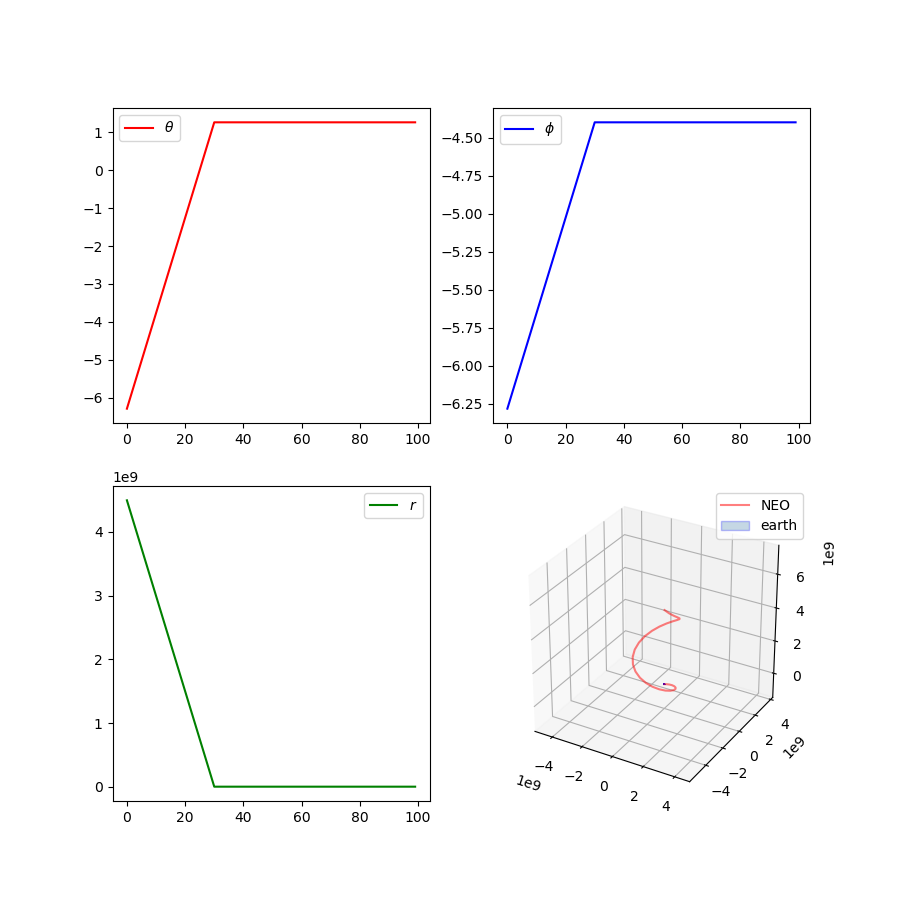

A Jupyter Widget

In [4]:
# NOTE: run this cell & interact with it below

ion() # enable interaction

# default values (NOTE: units are implicit)
time = arange(0, 100)
t_impact = 50
params = LaunchParams.from_impact_time(4*pi/t_impact, -2*pi, pi/t_impact, -2*pi, t_impact)

# earth is at a fixed location
EARTH = SphericalCoords(6.371e6, *mgrid[0:pi:11j, 0:2 * pi:11j])

fig = figure(figsize=(9, 9))
ax1, ax2, ax3, ax4 = subplot(221), subplot(222), subplot(223), subplot(224, projection='3d')

def plot_trajectories():
    global params # so that cell below updates correctly
    global theta_line, phi_line, r_line, neo_line
    
    sc, cc = params(time).spherical, params(time).cartesian
    
    theta_line,  = ax1.plot(time, sc.theta, 'r', label=r'$\theta$')
    phi_line,   = ax2.plot(time, sc.phi,   'b', label=r'$\phi$')
    r_line,     = ax3.plot(time, sc.r,     'g', label='$r$')
    neo_line,   = ax4.plot(cc.x, cc.y, cc.z, color='r', alpha=.5, label='NEO')
    earth_surf  = ax4.plot_surface(*EARTH.cartesian, facecolor='b', edgecolor='b', alpha=.25, label='earth')

    # fix for legend() bug
    earth_surf._facecolors2d = earth_surf._facecolors3d
    earth_surf._edgecolors2d = earth_surf._edgecolors3d
    equal_aspect(cc.x, cc.y, cc.z, ax4)

    for ax in (ax1, ax2, ax3, ax4):
        ax.legend()

def update_trajectories(m_theta, b_theta, m_phi, b_phi, t_impact):
    global params
    
    params = LaunchParams.from_impact_time(m_theta, b_theta, m_phi, b_phi, t_impact)
    
    sc, cc = params(time).spherical, params(time).cartesian

    theta_line.set_ydata(sc.theta)
    phi_line.set_ydata(sc.phi)
    r_line.set_ydata(sc.r)
    
    neo_line.set_xdata(cc.x)
    neo_line.set_ydata(cc.y)
    neo_line.set_3d_properties(cc.z)
    
    equal_aspect(cc.x, cc.y, cc.z, ax4)
    for ax in (ax1, ax2, ax3, ax4):
        ax.relim()
        ax.autoscale_view()
    
    fig.canvas.draw()
        
plot_trajectories()
interact(update_trajectories,
    m_theta  = FloatSlider(value = params.m_theta,  min=0,     max=4*pi/20, step=.01,  description=r'$m_\theta$'),
    b_theta  = FloatSlider(value = params.b_theta,  min=-2*pi, max=2*pi,    step=.1,   description=r'$b_\theta$'),
    m_phi    = FloatSlider(value = params.m_phi,    min=0,     max=4*pi/20, step=.01,  description=r'$m_\phi$'),
    b_phi    = FloatSlider(value = params.b_phi,    min=-2*pi, max=2*pi,    step=.1,   description=r'$b_\phi$'),
    t_impact = FloatSlider(value = params.t_impact, min=1,     max=30,      step=2,    description='$t_{impact}$'),
);

### animated trajectory

Once you have a trajectory you like, run the below cell to visualize it from all angles in 3D.

In [ ]:
# NOTE: run this cell

ioff()

fig = figure(figsize=(9, 9))
ax = fig.gca(projection='3d')

cc = params(time).cartesian

ax.plot(cc.x, cc.y, cc.z, color='r', alpha=.5, label='NEO')
_surf = ax.plot_surface(*EARTH.cartesian, facecolor='b', edgecolor='b', alpha=.25, label='earth')
_surf._facecolors2d = _surf._facecolors3d
_surf._edgecolors2d = _surf._edgecolors3d
equal_aspect(cc.x, cc.y, cc.z, ax)
ax.legend()

def animate(angle):
    ax.view_init(30, angle)
    return [fig]

anim = FuncAnimation(fig, animate, frames=360, interval=20, blit=True)
display(HTML(anim.to_html5_video()))